# Homework 6
Part 1: Softmax

Part 2: Bayes: MAP estimator for continuous data

Part 3: Naive Bayes: Bayesian spam filter (discrete date)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_28325/3459056358.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Part 1
When computing the output probabilities from margins $x_1,\ x_2,\ \ldots,\ x_C$, often (incorrectly) called *logits*, the exponential terms may be very large or very small. This can cause numerical or overflow errors (try `np.exp(1000)`).

Check that the following formula is correct for an arbitrary $A$:

$$
Softmax_i = \frac{e^{x_i}}{\sum\limits_{c=1}^{C} e^{x_c}} = \frac{e^{x_i-A}}{\sum\limits_{c=1}^{C} e^{x_c-A}}.
$$

A suitable choice for this fixed value $A$ is
$$
A = \underset{c}{\max} x_c.
$$

## Q1 (3pt) Write a function `compute_probabilities` that computes Softmax.

In [7]:
def compute_probabilities(X):
    """
    Computes Softmax, for each vector X[i, :].

    Args:
        X - (n, C) NumPy array (n datapoints each with C features)
    Returns:
        H - (n, C) NumPy array, where each row H[i,:] = Softmax(X[i,:])
    """
    
    # A = np.max(X, axis=1, keepdims=True)  # Not sure why this does not work
    A = np.max(X, axis=1)  
    e_x = np.exp(X - A[:, np.newaxis])   
    # sum_e_x = np.sum(e_x, axis=1, keepdims=True)[:,np.newaxis]                   
    sum_e_x = np.sum(e_x, axis=1)[:,np.newaxis]  
    H = e_x / sum_e_x                      
    return H

In [6]:
#Test yourself
from scipy.special import softmax
M = np.random.randint(-1000, 1000, size=(30,20))
assert np.allclose(compute_probabilities(M), softmax(M, axis=1))

# Part 2
In this Question you will work with dataset from Ch.2 in *Classification, Parameter Estimation and State
Estimation: An Engineering Approach Using MATLAB* by
R. Duin, F. van der Heijden, D. de Ridder, and D. M.
J. Tax https://go.exlibris.link/Y6BQ8cJ5

In [8]:
#data = pd.read_csv('data_bnrs.csv', header=None)
data = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2023_fall/data_bnrs.csv', header=None)

In [9]:
data.head()

,0,1,2
0,0.35029,0.79978,1
1,0.60302,0.97778,1
2,0.32696,0.74125,1
3,0.35015,0.83668,1
4,0.46741,0.94682,1


In [10]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

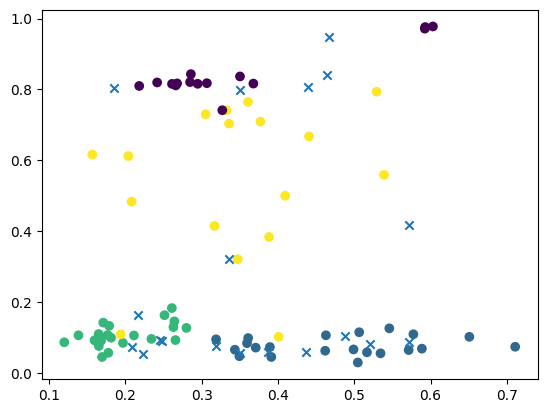

In [12]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.scatter(X_test[:,0], X_test[:,1], marker='x')

From the conditional probability formula, we know that
$$
p(y=c|x) = \frac{p(x, y=c)}{p(x)} = \frac{p(x|y=c)p(y=c)}{p(x)}, \quad c=1,2,3,4.
$$

Because the denominator doesn't depend on $c,$
$$
a(x) = \underset{c}{argmax}\ p(y=c|x) = \underset{c}{argmax}\ p(x|y=c)p(y=c).
$$

We will assume that conditional distribution $p(x|y=c)\sim N(\mu_c,\Sigma_c)$ you can use `multivariate_normal` from `scipy.stats` to calculate this value for the entier matix $X$ with datapoints in rows $X[i,:]$ as follows: `multivariate_normal(X, mean=, cov=)`.

For the Cost function, you can use the following decision rule:
$$
a(x) = \underset{c}{\arg \min}\ \text{Cost\_Matrix} \cdot \begin{bmatrix} p(y=1|x) \\ p(y=2|x) \\ p(y=3|x) \\ p(y=4|x) \end{bmatrix} = \underset{c}{\arg \min}\ \text{Cost\_Matrix} \cdot \begin{bmatrix} p(x|y=1)p(y=1) \\ p(x|y=2)p(y=2) \\ p(x|y=3)p(y=3) \\ p(x|y=4)p(y=4) \end{bmatrix}.
$$


## Q2 (8pt) Write the class `UserMAP` for maximum a posteriori estimator

In [13]:
from scipy.stats import multivariate_normal

In [53]:
class UserMAP():
    def __init__(self, cost=False):
        self.cost = cost

    def fit(self, X, y):
      """
      Calculate mean velues and covariance matrices for each class
      Calculate class distribution p(y)
      Store them as self. variables
      """
      self.classes = np.unique(y)
      self.means = np.zeros((len(self.classes), X.shape[1]))
      self.covariances = np.zeros((len(self.classes), X.shape[1], X.shape[1]))
      self.priors = np.zeros(len(self.classes))

      for i, c in enumerate(self.classes):
        X_c = X[y == c]
        self.means[i] = np.mean(X_c, axis=0)
        self.covariances[i] = np.cov(X_c, rowvar=False)
        self.priors[i] = len(X_c) / len(X)

    def posterior(self, X):
      """
      Calculate posterior pobabilities and return argmax
      """
      prob_posterior = np.zeros((X.shape[0], len(self.classes)))

      for i, _ in enumerate(self.classes):
          likelihood = multivariate_normal.pdf(X, mean=self.means[i], cov=self.covariances[i])
          posterior = likelihood * self.priors[i]
          prob_posterior[:,i] = posterior
          # posteriors = np.column_stack(posteriors)
      return np.argmax(prob_posterior, axis=1) + 1  # +1 to match class labels


    def posterior_cost(self, X):
      """
      Given the cost matrix and posterior probabilities, predict the class
      """
      cost_matrix = np.array([
        [ -0.20, 0.07, 0.07, 0.07 ],
        [  0.07,-0.15, 0.07, 0.07 ],
        [  0.07, 0.07,-0.05, 0.07 ],
        [  0.03, 0.03, 0.03, 0.03 ]])
      
      # Create empty array for posterior probabilities
      prob_posterior_cost = np.zeros((X.shape[0], len(self.classes)))

      # Iterate over classes
      for i, _ in enumerate(self.classes):
        # Calculate conditional probability
        prob_posterior_cost[:, i] = multivariate_normal.pdf(X, mean=self.means[i], cov=self.covariances[i]) * self.priors[i]

      # Multiply posterior probabilties by transpose of cost matrix
      # To get class costs
      class_costs = prob_posterior_cost.dot(cost_matrix.T)

      # Get the min of class_costs (we minimize the costs)
      return np.argmin(class_costs, axis=1)


    def predict(self, X):
      if self.cost == True:
        return self.posterior_cost(X)
      return self.posterior(X)

In [26]:
from mlxtend.plotting import plot_decision_regions

From the conditional probability formula, we know that
$$
p(y=c|x) = \frac{p(x, y=c)}{p(x)} = \frac{p(x|y=c)p(y=c)}{p(x)}, \quad c=1,2,3,4.
$$

Because the denominator doesn't depend on $c,$
$$
a(x) = \underset{c}{argmax}\ p(y=c|x) = \underset{c}{argmax}\ p(x|y=c)p(y=c).
$$

We will assume that conditional distribution $p(x|y=c)\sim N(\mu_c,\Sigma_c)$ you can use `multivariate_normal` from `scipy.stats` to calculate this value for the entier matix $X$ with datapoints in rows $X[i,:]$ as follows: `multivariate_normal(X, mean=, cov=)`.

For the Cost function, you can use the following decision rule:
$$
a(x) = \underset{c}{\arg \min}\ \text{Cost\_Matrix} \cdot \begin{bmatrix} p(y=1|x) \\ p(y=2|x) \\ p(y=3|x) \\ p(y=4|x) \end{bmatrix} = \underset{c}{\arg \min}\ \text{Cost\_Matrix} \cdot \begin{bmatrix} p(x|y=1)p(y=1) \\ p(x|y=2)p(y=2) \\ p(x|y=3)p(y=3) \\ p(x|y=4)p(y=4) \end{bmatrix}.
$$


##Q2 (8pt) Write the class `UserMAP` for maximum a posteriori estimator

In [54]:
clf = UserMAP()

In [55]:
clf.fit(X_train, y_train)

/home/tohab0g/.local/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Axes: >

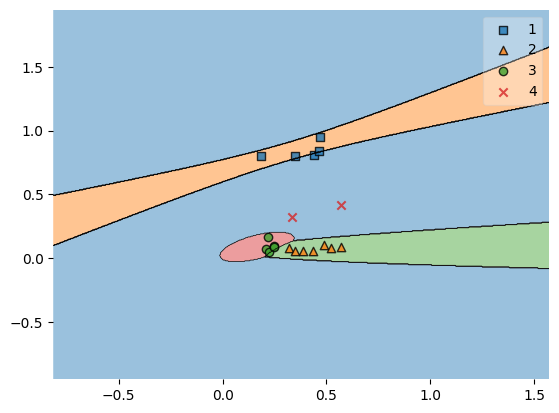

In [56]:
plot_decision_regions(X_test,y_test,clf)

In [57]:
clf_cost = UserMAP(cost=True)

In [58]:
clf_cost.fit(X_train, y_train)

<Axes: >

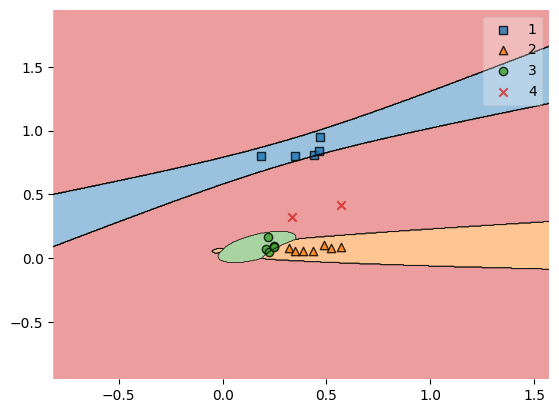

In [59]:
plot_decision_regions(X_test,y_test,clf_cost)

# Part 3
In this Question, you will apply Naive Bayes classifier to build a spam filter. Use dataset from https://www.kaggle.com/datasets/venky73/spam-mails-dataset?select=spam_ham_dataset.csv  It's *Enron email dataset,* a large collection of emails from the Enron Corporation.

In [62]:
!unzip archive.zip

Archive:  archive.zip
  inflating: spam_ham_dataset.csv    


In [63]:
import pandas as pd
data = pd.read_csv('spam_ham_dataset.csv')

texts = data['text'].values
target = data['label_num'].values
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [64]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

### Preprocessing and tokenization

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

Apply `CountVectorizer()` to the training data.

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

In [66]:
vec = CountVectorizer()

In [67]:
X_train_bow = vec.fit_transform(texts_train).toarray()
X_test_bow = vec.transform(texts_test).toarray()

Now you have the counts of the words from the bag of words in each e-mail.

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier.
Its a simple probabilistic model that assumes the independence of input features and computes the counting probabilities.

If you don't remember the math behind Naive Bayes, read https://scikit-learn.org/stable/modules/naive_bayes.html to help refresh your memory. Done? Good! Now let's implement that :)

For every word we will calculate its frequency in spam and in ham, it will be $p(word|y=0)$ and $p(word|y=0)$. To avoid devisions by zero instead of the formula
$$
p(word|y) =\frac{\#word \text{ in class y}}{\text{total # words in class } y}
$$
use
$$
p(word|y) =\frac{\delta+\#word \text{ in class y}}{\delta\cdot\text{vocabulary length} + \text{total # words in class } y}
$$

##Q3 (8pt) Write the class for Naive Bayes

In [68]:
delta = 1.0
class BinaryNaiveBayes:
#     delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=c) for c = 0,1
        self.p_y = np.array([np.sum(y == 0) / len(y), np.sum(y == 1) / len(y)])


        # count occurences of each word in texts with label 1 and label 0 separately
        word_counts_positive = np.sum(X[y == 1], axis = 0)
        word_counts_negative = np.sum(X[y == 0], axis = 0)
        # ^-- both must be vectors of shape [vocab_size].

        # finally, lets use those counts to estimate p(x | y = c) for c = 0, 1

        #<YOUR CODE HERE>

        self.p_x_given_positive = (delta + word_counts_positive) / np.sum(delta + word_counts_positive)

        self.p_x_given_negative = (delta + word_counts_negative) / np.sum(delta + word_counts_negative)
        # both must be of shape [vocab_size]; and don't forget to add self.delta!

        return self

    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}

        score_negative = X.dot(np.log(self.p_x_given_negative)) + np.log(self.p_y[0])
        score_positive = X.dot(np.log(self.p_x_given_positive)) + np.log(self.p_y[1])
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [69]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [70]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

Model accuracy: 0.971
Well done!


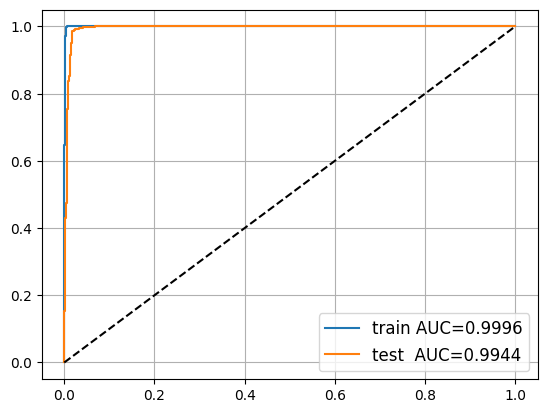

In [71]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. (The log of that fraction is called *logit.*) Here are top-25 words that have the __highest__ ratio of ${p(x_i | y=0)} \over {p(x_i | y=1)}$.

In [72]:
bow_vocabulary = vec.get_feature_names_out()

In [73]:
probability_ratio = 1/(naive_model.p_x_given_positive/naive_model.p_x_given_negative)
top_negative_words = bow_vocabulary[np.argsort(probability_ratio)[:25]]
assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[list(bow_vocabulary).index(word)]})")

#0	      nbsp	(ratio=0.0018332767128025555)
#1	     pills	(ratio=0.0027203460899650825)
#2	      2004	(ratio=0.0029664075453388087)
#3	      font	(ratio=0.0035348209672001365)
#4	 computron	(ratio=0.003988615550827182)
#5	        br	(ratio=0.00454088539632633)
#6	    viagra	(ratio=0.005676106745407913)
#7	        xp	(ratio=0.005676106745407913)
#8	    cialis	(ratio=0.006785231051981872)
#9	        td	(ratio=0.006944883547322622)
#10	      soft	(ratio=0.0074723430572458584)
#11	    moopid	(ratio=0.007977231101654363)
#12	   hotlist	(ratio=0.007977231101654363)
#13	     width	(ratio=0.008555291326411927)
#14	      meds	(ratio=0.008681104434153278)
#15	      href	(ratio=0.008810673157051089)
#16	       pro	(ratio=0.008944168204885196)
#17	        mx	(ratio=0.00908177079265266)
#18	  paliourg	(ratio=0.009370080976546395)
#19	      pain	(ratio=0.01017784657797281)
#20	        oo	(ratio=0.010356405289867069)
#21	 photoshop	(ratio=0.010541341098614695)
#22	     drugs	(ratio=0.0105413410986146

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay

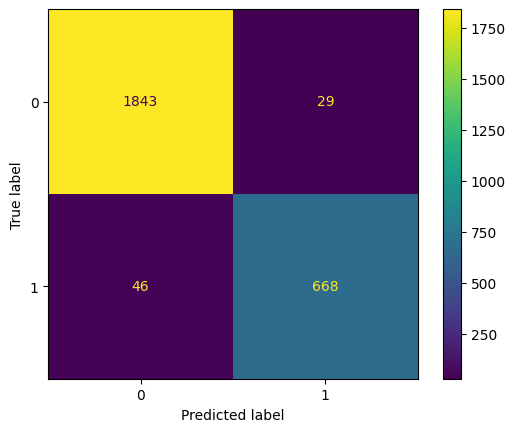

In [75]:
ConfusionMatrixDisplay.from_predictions(y_test, naive_model.predict(X_test_bow))

Now, let's do it with the built-in function and compare results

In [76]:
from sklearn.naive_bayes import MultinomialNB

In [77]:
model = MultinomialNB().fit(X_train_bow, y_train)

In [78]:
np.mean(y_test==model.predict(X_test_bow))

0.9709976798143851

Now lets try something less prehistoric: __Logistic Regression__. It turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

You can play with parameter $C=$ in LogisticRegression, it plays similar role as in SVM allowing slightly negative margins.

In [80]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(C = 0.2).fit(X_train_bow, y_train)

Model accuracy: 0.971
Well done!


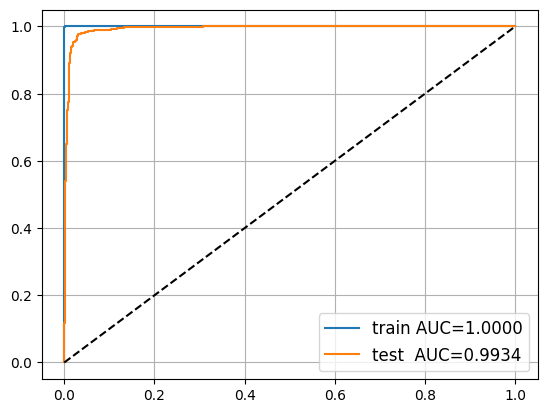

In [81]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

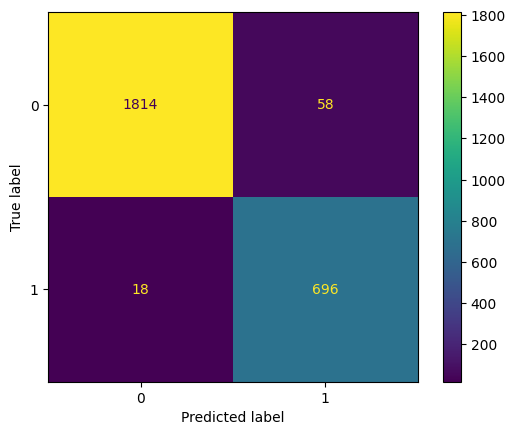

In [82]:
ConfusionMatrixDisplay.from_predictions(y_test, bow_model.predict(X_test_bow))

Finally, you can play with threshold to reduce the False Positive predictions, as you did in HW5. But let's better think about

## Q4 (1pt) How to update the Naive Bayes model after getting a new spam classification from a user?

Since the Naive model is determined by p(x(i) | y) and p(y), both of these these terms have to be updated for every i in order to update the entire model. After receiving a new spam classification from a user:
- Extract a feature for the new spam classification
- Combine new data with previous data
- Recalculate model parameters
- Calculate count for each word
- Find conditional probabilite for each word
- Train the model with new parameters